In [4]:
import pymongo
from pymongo import MongoClient

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["mydatabase"]
mycol = mydb["customers"]

x = mycol.find_one()

print(x)

None


In [1]:

import cv2
import threading
#from kafka import KafkaProducer
import base64
import json
import numpy as np
import datetime
from bson import ObjectId
import os
import sys
import multiprocessing
# from datetime import datetime
import pickle
import redis
import time
import requests
from common_utils import *
# import config
raw_image_path = '/home/maini/main/cameraEngine/savedimages/'

import camera_module
import dummy_cam

def config_file():
    cmd = os.system('v4l2-ctl --list-device | grep /dev/video > indexes.txt')

    config = [

    ]

    fr = open('indexes.txt','r')

    data = fr.read()
    data = data.split('\n')

    # print(data)


    camera_id = []

    counter = 0
    c = 0
    ids_list = ['cam2','cam1','cam3','cam4']#,'9cam','10cam','2cam','4cam','5cam','6cam']
    # ids_list = ['1cam','3cam','7cam','8cam','6cam','5cam','4cam','9cam','2cam']
    # ids_list = ['1cam','3cam','7cam','8cam','8cam','5cam','4cam','9cam','3cam']


    for i in data:
        if i == '':
            continue
        if counter %2 == 0:

            i = i.replace('\t','')
            # print(i)
            camera_id.append(i)
            config.append({'camera_id':i,'camera_index':ids_list[c]})
            
            c += 1

        
        counter += 1

    return config



def singleton(cls):
    instances = {}
    def getinstance():
        if cls not in instances:
            instances[cls] = cls()
        return instances[cls]
    return getinstance

@singleton
class MongoHelper:
    client = None
    def __init__(self):
        if not self.client:
            self.client = MongoClient(host='localhost', port=27017)

        self.db = self.client[settings.MONGO_DB]
        # if settings.DEBUG:
            # self.db.set_profiling_level(2)
        # placeholder for filter
    """
    def getDatabase(self):
        return self.db
    """

    def getCollection(self, cname, create=False, codec_options=None):
        _DB = "LIVIS"
        DB = self.client[_DB]
        return DB[cname]

@singleton
class CacheHelper():
    def __init__(self):
        self.redis_cache = redis.StrictRedis(host="localhost", port="6379", db=0, socket_timeout=1)
        print("REDIS CACHE UP!")

    def get_redis_pipeline(self):
        return self.redis_cache.pipeline()
    
    #should be {'key'  : 'value'} always
    def set_json(self, k, v):
        try:
            #k, v = list(dict_obj.items())[0]
            v = pickle.dumps(v)
            return self.redis_cache.set(k, v)
        except redis.ConnectionError:
            return None

    def get_json(self, key):
        try:
            temp = self.redis_cache.get(key)
            #print(temp)\
            if temp:
                temp= pickle.loads(temp)
            return temp
        except redis.ConnectionError:
            return None
        return None

    def execute_pipe_commands(self, commands):
        #TBD to increase efficiency can chain commands for getting cache in one go
        return None

def create_folder():
    main_path = raw_image_path
    date_folder = datetime.datetime.now().strftime('%y_%m_%d')
    date_path = main_path + date_folder
    part_folder = datetime.datetime.now().strftime('%H_%M_%S')
    part_path = date_path+'/'+part_folder
    print(date_path,os.path.exists(date_path))
    print(part_path,os.path.exists(part_path))
    try:
        if not(os.path.exists(date_path)):
            print('Creating Date Path')
            os.mkdir(date_path)
    except Exception as e:
        print(e)
    try:
        if not(os.path.exists(part_path)):
            print('Creating Part Path')
            os.mkdir(part_path)
        return part_path
    except Exception as e:
        print(e)

def camPreview(previewName, camID, preprocess=[]):
    print("previewName-------",previewName)
    # print(preprocess)
    frame_counter = 0

    
    # rakshith start
    # cam = cv2.VideoCapture((camID),cv2.CAP_V4L2)
    cam_data = camID.split(':')
    if cam_data[0] == 'baumer' :
        cam = camera_module.camera('baumer',cam_data[1])
    elif cam_data[0] == 'dummy2':
        cam = dummy_cam.cam2()
    elif cam_data[0] == 'dummy3':
        cam = dummy_cam.cam3()
    elif cam_data[0] == 'dummy4':
        cam = dummy_cam.cam4()

    # rakshith stop

    # cam = cv2.VideoCapture(int(camID))

    # pipeline = 'v4l2src device=/dev/video0 ! video/x-raw, framerate=30/1,width=1920,height=1080 ! videoconvert ! appsink'
    # width = 1920
    # height = 1080
    # width = 1280
    # height = 1080
    width = 1920
    height = 1080
    

    #rakshith start
    
    # if cam.isOpened():
    #     cam.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    #     cam.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    #     start_frame_number = 20
    #     cam.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
    #     cam.set(cv2.CAP_PROP_FOURCC,cv2.VideoWriter_fourcc('M','J','P','G'))

    #     # cam.set(cv2.CAP_PROP_FPS, 9)
    #     # print(camID)
    #     # print(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #     # print(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
    #     # cam.set(cv2.CAP_PROP_FOURCC,cv2.VideoWriter_fourcc('M','J','P','G'))
    #     # print(dir(cam))
    #     time.sleep(0.1)
    #     rval, frame = cam.read()
    #     print(frame.shape)
    #     # time.sleep(5)

    # else:
    #     print(previewName,'not responding')
    #     rval = False
    # print(previewName,rval)
    print(previewName)
    #rakshith stop

    

    total_count = 12
    # measured = False
    print('Programme Restarted------------------------------------------------------------------------------------------')

    while True:
        #rakshith start

        # rval, frame = cam.read()
        frame = cam.fetch_image()
        #rakshith stop
        # img = str(ObjectId()) + '.jpg'
        # b,g,r = cv2.split(frame)
        # frame = b
        
        # # frame = cv2.resize(frame,(1080,720))
        # cv2.imwrite(img, frame)
        
        # with open(img, 'rb') as f:
        #     im_b64 = base64.b64encode(f.read())
        # payload_video_frame = {"frame": str(im_b64)}
        # os.remove(img)

        # frame = cv2.resize(frame,(1920,1080))
        if previewName == 'cam3' and CacheHelper().get_json("measure_length"):
            # rval, frame = cam.read()
            CacheHelper().set_json('Stage2_Status',"started")
            part_path = create_folder()
            CacheHelper().set_json('part_path_cam_service',part_path)
            print('Part path',part_path)
            if not part_path:
                part_path = create_folder()
            # rval, frame = cam.read()
            # rval, frame = cam.read()
            cv2.imwrite('/home/maini/main/cameraEngine/savedimages/measurement.jpg', frame)
            CacheHelper().set_json('measurement', frame)
            # temp_start = datetime.datetime.now()
            # temp_count = 0
            # while 1:
                
            #     cv2.imwrite(part_path+'/measurement'+str(temp_count)+'.jpg', frame)
            #     temp_count += 1
            #     rval, frame = cam.read()
            #     if datetime.datetime.now() - temp_start >= datetime.timedelta(seconds=5):
            #         break
            cv2.imwrite(part_path+'/measurement.jpg', frame)
            cv2.imwrite('measurement.jpg', frame)
            print('\n\n\n\n\n\n\nMeasured\n\n\n\n\n\n')
            CacheHelper().set_json('measurement_complete',True)
            CacheHelper().set_json('measure_length',False)

        if CacheHelper().get_json(previewName+'_Start_Insp'):
            if frame_counter == 0:
                start = datetime.datetime.now()
                part_path = CacheHelper().get_json('part_path_cam_service')
                print('Part path',part_path)
                if not part_path:
                    part_path = create_folder()
                # if previewName=='cam3':
                #     cv2.imwrite('/home/maini/main/cameraEngine/savedimages/measurement.jpg', frame)
                #     CacheHelper().set_json('measurement', frame)
                #     cv2.imwrite(part_path+'/measurement.jpg', frame)
                #     print('\n\n\n\n\n\n\nMeasured\n\n\n\n\n\n')

            topic1=str(previewName)+"_"+str(frame_counter)
            #rakshith start

            # rval, frame = cam.read()
            frame = cam.fetch_image()
            #rakshith stop
            cv2.imwrite('/home/maini/main/cameraEngine/savedimages/raw_'+str(previewName)+'_'+str(frame_counter)+'.jpg', frame)

            cv2.imwrite(part_path+'/'+str(previewName)+'_'+str(frame_counter)+'.jpg', frame)

            CacheHelper().set_json(topic1, frame)
            print("topic1*********************",topic1)
            CacheHelper().set_json('Trigger_'+previewName,True)
            print(topic1,'Trig',frame_counter)
            frame_counter += 1
            
            if frame_counter==total_count:
                frame_counter = 0
                # measured = False
                # if previewName=='cam3':
                #     cv2.imwrite('/home/maini/main/cameraEngine/savedimages/measurement.jpg', frame)
                #     CacheHelper().set_json('measurement', frame)
                #     cv2.imwrite(part_path+'/measurement.jpg', frame)
                #     print('\n\n\n\n\n\n\nMeasured\n\n\n\n\n\n')
                print(previewName,"*****************complete****************")
                CacheHelper().set_json(previewName+'_completed',True)
                print(previewName,datetime.datetime.now() - start)
                # break
                CacheHelper().set_json(previewName+'_Start_Insp',False)
                break
            CacheHelper().set_json(previewName+'_Start_Insp',False)
        # break
    #rakshith start
    # cam.release()        
    #rakshith stop
    cv2.destroyAllWindows()

def reset():
    CacheHelper().set_json('cam1_completed',False)
    CacheHelper().set_json('cam2_completed',False)
    CacheHelper().set_json('cam3_completed',False)
    CacheHelper().set_json('cam4_completed',False)
    CacheHelper().set_json('measurement_complete',False)
    CacheHelper().set_json('measure_length',False)
    CacheHelper().set_json('cam1_Start_Insp',False)
    CacheHelper().set_json('cam2_Start_Insp',False)
    CacheHelper().set_json('cam3_Start_Insp',False)
    CacheHelper().set_json('cam4_Start_Insp',False)

def __main__():
# Create threads as follows
    print("main function")
    thread_pool = {}  
    # f = open('config.json', 'r')
    # distros_dict = json.load(f)
    distros_dict = config_file()
    print(distros_dict)
    # f.close()
    reset()
    print("after reset")
    for distro in distros_dict:  
        print("disto:::",distro)
        if 'preprocess' not in distro:
            distro['preprocess'] = [] 
        
        thread_pool[distro['camera_id']] = multiprocessing.Process(target=camPreview, args=(distro['camera_index'],distro['camera_id'], distro['preprocess']))
        # print()        
    for tt in thread_pool:
        # print('process',tt)
        thread_pool[tt].start()
        print(tt,"--------------------------------")
    for tt in thread_pool:
        thread_pool[tt].join()

    
    
if __name__ == "__main__":
    __main__() 
    cv2.destroyAllWindows()


d:\Anaconda\envs\mmnew\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\envs\mmnew\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\Anaconda\envs\mmnew\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


ModuleNotFoundError: No module named 'common_utils'

In [4]:

from livis.settings import MONGO_DB
import pymongo
def singleton(cls):
    instances = {}
    def getinstance():
        if cls not in instances:
            instances[cls] = cls()
        return instances[cls]
    return getinstance

@singleton
class MongoHelper:
    client = None
    def __init__(self):
        if not self.client:
            self.client = pymongo.MongoClient(host='localhost', port=27017)

        self.db = self.client[MONGO_DB]
        # if settings.DEBUG:
            # self.db.set_profiling_level(2)
        # placeholder for filter
    """
    def getDatabase(self):
        return self.db
    """

    def getCollection(self, cname, create=False, codec_options=None):
        _DB = "LIVIS"
        DB = self.client[_DB]
        return DB[cname]


def list_specific_jig(jig_type):

    message = None
    status_code = None

    
   
    if jig_type is None:
        message = "jig_type not provided"
        status_code = 400
        return message,status_code

    try:
        mp = MongoHelper().getCollection('jig')
    except:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code
   
    p = [i for i in mp.find()]
   
    new_list = []
   
    for i in p:
       
        if i['jig_type'] == jig_type:
       
            new_list.append(i)
       
    return new_list,200

In [7]:
jig_type = 'AGILIS'
new_list = list_specific_jig(jig_type)
new_list

([{'_id': ObjectId('63be84976826d4edf77b1b54'),
   'jig_type': 'AGILIS',
   'oem_number': '0N-33405',
   'heatsink_match': 'HSC123',
   'palette_match': 'P-123',
   'kanban': [{'part_number': ['FGY100T65'],
     'position': 5,
     'part_type': 'IGBT'}],
   'vendor_match': ['1,15,4'],
   'is_deleted': False,
   'full_img': [{'cam_name': 'extreme_left_camera', 'regions': []},
    {'cam_name': 'left_camera', 'regions': []},
    {'cam_name': 'middle_camera', 'regions': []},
    {'cam_name': 'right_camera', 'regions': []},
    {'cam_name': 'extreme_right_camera', 'regions': []}]}],
 200)

In [7]:
def config_file1():
    config = []
    config.append({'camera_id':"baumer:192.168.1.4",'camera_index':"cam1"})
    config.append({'camera_id':"baumer:192.168.1.3",'camera_index':"cam2"})
    return config

In [2]:
user_details = {'user_id': 'b05cc995-b6b6-40ec-bd55-704c326339e0', 'username': 'anusha', 'role_name': 'admin'}
user_name = user_details['user_id']
print(type(user_name))

<class 'str'>


In [8]:
def config_file1():
    baumer_ip = []
    baumer_ip.append("192.168.1.4")
    baumer_ip.append("192.168.1.3")
    return baumer_ip

In [17]:
from common.utils import RedisKeyBuilderServer,CacheHelper,MongoHelper
import sys
import sys
sys.path.insert(0,"../livis/")
from settings import REDIS_CLIENT_HOST
from settings import REDIS_CLIENT_PORT
from settings import WORKSTATION_COLLECTION

original_frame_keyholder = 'original-frame'

mp = MongoHelper().getCollection(WORKSTATION_COLLECTION)

p = [p for p in mp.find()]

workstation_id = p[0]['_id']
print(workstation_id)

data = RedisKeyBuilderServer(workstation_id).workstation_info
cam_list = []
key_list = []
cap_list = []
for cam in data['camera_config']['cameras']:
    camera_index = cam['camera_id']
    camera_name = cam['camera_name']
    key = RedisKeyBuilderServer(workstation_id).get_key(cam['camera_id'],original_frame_keyholder) #WS-01_0_original-frame
    key_list.append(key)

5f4cce083f8fa13b3271656b


In [21]:
key_list[0]

'ws_01_1_original-frame'

In [19]:
key_list

['ws_01_1_original-frame', 'ws_01_2_original-frame']

In [34]:
from common import camera_module
baumer_ip = config_file1()
baumer_ip[0]
cam_1 = camera_module.camera('baumer',baumer_ip[0])

NotConnectedException: NotConnectedException: No device with '192.168.1.4' found.

ImproperlyConfigured: Requested setting INSTALLED_APPS, but settings are not configured. You must either define the environment variable DJANGO_SETTINGS_MODULE or call settings.configure() before accessing settings.

In [15]:
from common.utils import *
from django.utils import timezone
from bson import ObjectId
# from toyoda.utils import generate_QRcode_util
# from toyoda.utils import get_inspection_qc_list
from copy import deepcopy
import sqlite3
from xlsxwriter import Workbook
import datetime
import pymongo
from bson import ObjectId
import datetime
from datetime import date
import calendar
from csv import DictWriter

try:
    from_date = data['from_date']
except:
    from_date = None
try:
    to_date = data['to_date']
except:
    to_date = None
try:
    jig_type = data['feature_type']
except:
    jig_type = None
try:
    operator_name = data['operator_name']
except:
    operator_name = None    
try:
    status_end = data['status_type']
except:
    status_end = None  
    
try:
    on_number = data['on_number']
except:
    on_number = None  
try:
    serial_number = data['serial_number']
except:
    serial_number = None  		
        


query_1 = []
query_2 = []
resp = {}
resp_list = []
today = date.today()
month = today.strftime("%m")
year = today.strftime("20%y")
end_date = calendar.monthrange(int(year), int(month))
end_date  = str(end_date[1])
start = datetime.date(int(year), int(month), 1)
end = datetime.date(int(year), int(month), int(end_date))
# start = datetime.date(2021, 12, 23)
# print(start)
# end = datetime.date(2021, 12, 23)
# print(end)

if (from_date is not None) :
    query_1.append({'createdAt': {"$gte":from_date}})#,"$lte":to_date
elif (from_date is None ) :
    query_1.append({'createdAt': {"$gte":str(start)}})#,"$lte":to_date
if (to_date is not None) :
    query_1.append({'completedAt': {"$lte":to_date}})
elif (to_date is None) :
    query_1.append({'completedAt': {"$lte":str(end)}})
if jig_type is not None :
    query_1.append({'jig_details.jig_type': jig_type})
if on_number is not None :
    query_1.append({'jig_details.oem_number': on_number})
if operator_name is not None :
    query_1.append({'user.user_id': operator_name})
if status_end is not None:
    query_1.append({'status_end':status_end})
if serial_number is not None:
    query_1.append({'serial_no':serial_number})		
print(operator_name)
print(serial_number,'ssssssssssssssssssssssssssssssssssss')
print(query_1)



myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["LIVIS"]

all_lst = mydb.collection_names()

insp_lst = []

for a_lst in all_lst:
    if 'INSPECTION' in a_lst:
            insp_lst.append(a_lst)

for i_lst in insp_lst:

    #COLL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
    process_collection = MongoHelper().getCollection(i_lst)
    
    
    if bool(query_1):
        pr_ids = [i['_id'] for i in process_collection.find({"$and":query_1})]
    else:
        pr_ids = [i['_id'] for i in process_collection.find()]
        

        # for ind , pr_id in enumerate(pr_ids):
        #     res = process_collection.find({"_id":pr_id})
        #     #print(pr_id)
        #     #print(res)
        #     for r in res:
        #         if 'approved_by' in list(r.keys()):
                
        #             name = get_name_byid(r["approved_by"])
                
        #             resp_list.append({"id":ind,
        #                         "on_number": r["jig_details"]["oem_number"],
        #                         'operator_name': r['user']['name'] ,
        #                         'jig_type':r["jig_details"]["jig_type"],
        #                         "serial_number":r["serial_no"],
        #                         'scanned_at':r["createdAt"],
        #                         # "completed_at":r["completedAt"],
        #                         "status":r["status_end"],
        #                         "num_retry":r["num_retry"],
        #                         "approved_by":name})
        #         else:
        #             resp_list.append({"id":ind,
        #                 "on_number": r["jig_details"]["oem_number"],
        #                 'operator_name': r['user']['name'] ,
        #                 'jig_type':r["jig_details"]["jig_type"],
        #                 "serial_number":r["serial_no"],
        #                 'scanned_at':r["createdAt"],
        #                 # "completed_at":r["completedAt"],
        #                 "num_retry":r["num_retry"],
        #                 "status":r["status_end"],
        #                 "approved_by":None})
                   
                   
                   


None
None ssssssssssssssssssssssssssssssssssss
[{'createdAt': {'$gte': '2023-01-01'}}, {'completedAt': {'$lte': '2023-01-31'}}]


C:\Users\Rakshith\AppData\Local\Temp\ipykernel_5388\3259191371.py:92: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  all_lst = mydb.collection_names()


In [22]:
from paddleocr import PaddleOCR,draw_ocr 
import os
import matplotlib.pyplot as plt
# %matplotlib inline
import cv2
import torch
import pandas as pd
from pymongo import MongoClient
from livis import settings as s
from iteration_utilities import unique_everseen

def singleton(cls):
    instances = {}
    def getinstance():
        if cls not in instances:
            instances[cls] = cls()
        return instances[cls]
    return getinstance


@singleton
class MongoHelper:
    client = None
    def __init__(self):
        if not self.client:
            self.client = MongoClient(host=s.MONGO_SERVER_HOST, port=s.MONGO_SERVER_PORT)
        self.db = self.client[s.MONGO_DB]

    def getDatabase(self):
        return self.db

    def getCollection(self, cname, create=False, codec_options=None):
        _DB = s.MONGO_DB
        DB = self.client[_DB]
        if cname in s.MONGO_COLLECTIONS:
            if codec_options:
                return DB.get_collection(s.MONGO_COLLECTIONS[cname], codec_options=codec_options)
            return DB[s.MONGO_COLLECTIONS[cname]]
        else:
            return DB[cname]

# mp = MongoHelper().getCollection('jig')

# s = [p for p in mp.find()]

# s=s[0]
mp = MongoHelper().getCollection("jig")
for x in mp.find():
    if x['oem_number'] == 'ON-2213':
        kanban = x.get('kanban')
        if len(kanban) == 10:
            kanban = kanban[0:5]
        elif len(kanban) == 8:
            kanban = kanban[0:4]
        elif len(kanban) == 6:
            kanban = kanban[0:3]
        else:
            kanban	
        print(kanban)    				
# print(s['oem_number'])
# ON-2213
# ocr = PaddleOCR(use_angle_cls=True,use_gpu=True)
# # result = ocr.ocr(img_path)
# # print("======================")
# font = r"D:\24JAN\simfang.ttf"
# img_path = r"D:\24JAN\VCXG-201C.R\DATA\image0000035.jpg"
# model_dir = "D:/Segmentatin_yolo/LINCODE_AI_WORKER/segment/LINCODE_AI/"
# weights_path = "D:/24JAN/best.pt"

# def model_torch(img_path):
# 	img = cv2.imread(img_path)
# 	final_img = img.copy()
# 	model = torch.hub.load(model_dir,'custom',path=weights_path,source = 'local',force_reload=True,autoshape=True)
# 	model.conf = 0.25
# 	model.iou = 0.1
# 	results = model(img,size=1280)
# 	results.xyxy[0] 
# 	df = pd.DataFrame(results.pandas().xyxy[0]).sort_values('xmin')
# 	df_gen = df.loc[df.name == 'IGBT']
# 	return df_gen,final_img

# def get_kanban(oem_number):
# 	mp = MongoHelper().getCollection("jig")
# 	for x in mp.find():
# 		if x['oem_number'] == oem_number:
# 			kanban = x.get('kanban')
# 			return kanban

# def check_kanban(actual_value,predicted_value):
# 	position = {'position_present':[],'position_absent':[],'status':[]}
# 	position_actual = []
# 	position_predict = []
# 	isAccepted  = []
# 	status = []
# 	for actual,predicted in zip(actual_value,predicted_value):
# 		if actual['part_number'] == predicted['part_number']:
# 			position['position_present'].append(actual['position'])
# 			isAccepted.append('Accepted')  
# 		else:
# 			position['position_absent'].append(actual['position'])
# 			isAccepted.append('Rejected')  
# 	for value in actual_value:
# 		position_actual.append(value['position'])
# 	for value in predicted_value:
# 		position_predict.append(value['position']) 
# 	for i in position_actual:
# 		if i in position_predict:
# 			print(i)
# 		else:
# 			position['position_absent'].append(i)
# 			isAccepted.append('Rejected')  
# 	if 'Rejected' in isAccepted:
# 		position['status'].append('Rejected')
# 	else:
# 		position['status'].append('Accepted')
# 	print(isAccepted)		
# 	return  position                                 
  
# def get_ocr(img_path,oem_number):
# 	count = 1
# 	results_label = []
# 	actual = []
# 	df_gen,final_img = model_torch(img_path)
# 	for index, rows in df_gen.iterrows():
# 		ymin = int(rows["ymin"]) - 20
# 		xmax = int(rows["xmax"]) + 40
# 		ymax = int(rows["ymax"]) + 20 
# 		xmin = int(rows["xmin"]) - 40
# 		img_crp_save = final_img[ymin:ymax,xmin:xmax]
# 		results = ocr.ocr(img_crp_save)
# 		for result in results:
# 			boxes = [line[0] for line in result]
# 			labels = [line[1][0] for line in result]
# 			scores = [line[1][1] for line in result]
# 			kanban = get_kanban(oem_number)
# 			print(labels)
# 			for item in kanban:
# 				for i in item['part_number']:
# 					if i in labels:
# 						results_label.append({'part_number':[i] ,'position':count})
# 		count = count + 1
# 	return results_label 

# oem_number = '0N-456789'
# results_label= get_ocr(img_path,oem_number)
# actual_value = get_kanban(oem_number)
# predicted_value = list(unique_everseen(results_label))
# position  = check_kanban(actual_value,predicted_value)
# print(position)


# python tools/infer_det.py -c configs/det/det_mv3_db.yml -o Global.infer_img="./doc/imgs_en/image0000035.jpg" Global.pretrained_model="./output/igb_version_1/iter_epoch_100"

[{'part_number': ['30APF10'], 'position': 1, 'part_type': 'IGBT'}, {'part_number': ['K100T60'], 'position': 2, 'part_type': 'IGBT'}, {'part_number': ['40N120FL2'], 'position': 3, 'part_type': 'IGBT'}, {'part_number': ['K100T60'], 'position': 4, 'part_type': 'IGBT'}, {'part_number': ['R6076ENZ4'], 'position': 5, 'part_type': 'IGBT'}]


In [9]:
import os
print(os.getcwd())

# if (os.getcwd().split('/')[-1]) == "livis":
#     import livis.settings as s
# else:
# sys.path.insert(0,os.getcwd()+"/livis")
# import settings as s

d:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND


In [30]:
dict2 = {"prediction": [{"part_number": ["30APF10"], "position": 6}, {"part_number": ["K100T60"], "position": 7},
{"part_number": ["40N120FL2"], "position": 8}, {"part_number": ["K100T60"], "position": 9}, {"part_number":
["R6076ENZ4"], "position": 10}]}

dict = {"prediction": [{"part_number": ["30APF10"], "position": 1}, {"part_number": ["K100T60"], "position": 2},
{"part_number": ["40N120FL2"], "position": 3}, {"part_number": ["K100T60"], "position": 4}, {"part_number":
["R6076ENZ4"], "position": 5}]}

final_dictionary = dict + dict2
print(final_dictionary)
# a[1] = a[1],b[1] 
# a[2] = a[2],b[2] 
# a[3] = a[3],b[3] 

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [33]:
from collections import defaultdict

d2 = {"prediction": [{"part_number": ["30APF10"], "position": 6}, {"part_number": ["K100T60"], "position": 7},
{"part_number": ["40N120FL2"], "position": 8}, {"part_number": ["K100T60"], "position": 9}, {"part_number":
["R6076ENZ4"], "position": 10}]}

d1 = {"prediction": [{"part_number": ["30APF10"], "position": 1}, {"part_number": ["K100T60"], "position": 2},
{"part_number": ["40N120FL2"], "position": 3}, {"part_number": ["K100T60"], "position": 4}, {"part_number":
["R6076ENZ4"], "position": 5}]}

dd = defaultdict(list)

for d in (d1, d2): # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
    
print(dd) 

defaultdict(<class 'list'>, {'prediction': [[{'part_number': ['30APF10'], 'position': 1}, {'part_number': ['K100T60'], 'position': 2}, {'part_number': ['40N120FL2'], 'position': 3}, {'part_number': ['K100T60'], 'position': 4}, {'part_number': ['R6076ENZ4'], 'position': 5}], [{'part_number': ['30APF10'], 'position': 6}, {'part_number': ['K100T60'], 'position': 7}, {'part_number': ['40N120FL2'], 'position': 8}, {'part_number': ['K100T60'], 'position': 9}, {'part_number': ['R6076ENZ4'], 'position': 10}]]})


d:\Anaconda\envs\mmdatanew\lib\site-packages\pkg_resources\_vendor\pyparsing.py:943: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
d:\Anaconda\envs\mmdatanew\lib\site-packages\pkg_resources\_vendor\pyparsing.py:3226: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  elif isinstance( exprs, collections.Iterable ):


[2023/01/26 13:14:22] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\Rakshith/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\Rakshith/.paddleocr/whl\\det\\ch\\ch_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_scor

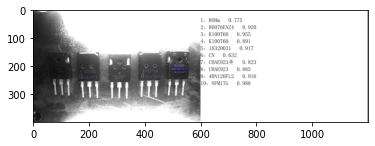

In [1]:
# pip install paddlepaddle-gpu
# pip install paddleocr


from paddleocr import PaddleOCR,draw_ocr 
import os
import matplotlib.pyplot as plt
# %matplotlib inline
import cv2
ocr = PaddleOCR(use_angle_cls=True)

# result = ocr.ocr(img_path)
# print("======================")
out_path = 'C:\\Users\\Rakshith\\Downloads\\images\\output_images'
font = r"D:\24JAN\simfang.ttf"
img_path = r"D:\24JAN\VCXG-201C.R\DATA\image0000035.jpg"
print("redddddddddddddddddddd1",img_path)
result = ocr.ocr(img_path)
for result in result:
    result = result

def save_ocr(img_path, out_path, result, font):

    save_path = os.path.join(out_path, img_path.split('/')[-1] + 'output')

    image = cv2.imread(img_path)
    print("redddddddddddddddddddd2",img_path)
    boxes = [line[0] for line in result]
    txts = [line[1][0] for line in result]
    scores = [line[1][1] for line in result]

    im_show = draw_ocr(image, boxes, txts, scores, font_path=font)
    print("redddddddddddddddddddd3",img_path)
    # cv2.imwrite(save_path, im_show)
    cv2.imwrite("drwdrw2.jpg", im_show)

    img = cv2.cvtColor(im_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

# for value,label,score in zip(boxes,labels,scores):
		# 	x1 = int(value[0][0])
		# 	y1 = int(value[0][1])
		# 	x2 = int(value[2][0])
		# 	y2 = int(value[2][1])
		# 	color  = (0,0,255)
		# 	text_color  = (255,255,255)
		# 	img_crp_save = cv2.rectangle(img_crp_save, (x1, y1), (x2, y2), color, 2)
		# 	(w, h), _ = cv2.getTextSize(
		# 			label +' '+ str(score)[:4], cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
		# 	img_crp_save = cv2.rectangle(img_crp_save, (x1, y1 - 20), (x1 + w, y1), color, -1)
		# 	img_crp_save = cv2.putText(img_crp_save, label +' '+ str(score)[:4], (x1, y1 - 5),
		# 						cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
		# cv2.imwrite('C:/Users/Rakshith/Downloads/images/image'+str(count)+'.png', img_crp_save)
save_ocr(img_path, out_path, result, font)

In [8]:
from LincodeOCR.tools.infer import predict_system
import cv2
image = cv2.imread(r"D:\24JAN\VCXG-201C.R\DATA\image0000035.jpg")
dt_boxes, rec_res, time_dict = predict_system.lincode_ocr(image)
print(rec_res)

usage: ipykernel_launcher.py [-h] [--use_gpu USE_GPU] [--use_xpu USE_XPU]
                             [--use_npu USE_NPU] [--ir_optim IR_OPTIM]
                             [--use_tensorrt USE_TENSORRT]
                             [--min_subgraph_size MIN_SUBGRAPH_SIZE]
                             [--precision PRECISION] [--gpu_mem GPU_MEM]
                             [--image_dir IMAGE_DIR] [--page_num PAGE_NUM]
                             [--det_algorithm DET_ALGORITHM]
                             [--det_model_dir DET_MODEL_DIR]
                             [--det_limit_side_len DET_LIMIT_SIDE_LEN]
                             [--det_limit_type DET_LIMIT_TYPE]
                             [--det_box_type DET_BOX_TYPE]
                             [--det_db_thresh DET_DB_THRESH]
                             [--det_db_box_thresh DET_DB_BOX_THRESH]
                             [--det_db_unclip_ratio DET_DB_UNCLIP_RATIO]
                             [--max_batch_size MAX_BATCH_SIZE

AssertionError: 

In [4]:
import cv2
import glob
count = 0
for i in glob.glob(r"C:\Users\Rakshith\Downloads\Halonix\Halonix\NOK\*.jpg"):
    img = cv2.imread(i)
    img = cv2.resize(img,(1024,1024))
    cv2.imwrite("D:/Anomaly-Detection-Localization-master (2)/Anomaly-Detection-Localization-master/mvtec/classic_stripes/test/bad/0"+str(count)+".png",img)
    count = count + 1

In [7]:
from datetime import date
import calendar
import datetime
today = date.today()
month = today.strftime("%m")
year = today.strftime("20%y")
end_date = calendar.monthrange(int(year), int(month))
end_date  = str(end_date[1])
start = datetime.date(int(year), int(month), 1)
end = datetime.date(int(year), int(month), int(end_date))

In [18]:
now = datetime.now()
current_date_time = now.strftime("%d-%m-%Y %H:%M") 
print(current_date_time) 

26-01-2023 15:21


In [ ]:
[alpha=1.0, 
benchmark=False, 
beta=1.0, 
cls_batch_num=6, 
cls_image_shape='3, 48, 192', 
cls_model_dir='./inference/cls/', 
cls_thresh=0.9, 
cpu_threads=10, 
crop_res_save_dir='./output', 
det_algorithm='DB', 
det_box_type='quad', 
det_db_box_thresh=0.6, 
det_db_score_mode='fast', 
det_db_thresh=0.3, 
det_db_unclip_ratio=1.5, 
det_east_cover_thresh=0.1, 
det_east_nms_thresh=0.2, 
det_east_score_thresh=0.8, 
det_limit_side_len=960, 
det_limit_type='max', 
det_model_dir='./inference/det/', 
det_pse_box_thresh=0.85, 
det_pse_min_area=16, 
det_pse_scale=1, 
det_pse_thresh=0, 
det_sast_nms_thresh=0.2, 
det_sast_score_thresh=0.5, 
draw_img_save_dir='./inference_results', 
drop_score=0.5, e2e_algorithm='PGNet', 
e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', 
e2e_limit_side_len=768, 
e2e_limit_type='max', 
e2e_model_dir=None, 
e2e_pgnet_mode='fast', 
e2e_pgnet_score_thresh=0.5, 
e2e_pgnet_valid_set='totaltext', 
enable_mkldnn=False, 
fourier_degree=5, 
gpu_mem=500, 
image_dir=None, 
ir_optim=True, 
label_list=['0', '180'], 
max_batch_size=10, 
max_text_length=25, 
min_subgraph_size=15, 
page_num=0, 
precision='fp32', 
process_id=0, 
rec_algorithm='SVTR_LCNet', 
rec_batch_num=6, 
rec_char_dict_path='./ppocr/utils/ppocr_keys_v1.txt',
rec_image_inverse=True, 
rec_image_shape='3, 48, 320', 
rec_model_dir='./inference/rec/', 
save_crop_res=False, 
save_log_path='./log_output/', 
scales=[8, 16, 32], 
show_log=True, 
sr_batch_num=1, 
sr_image_shape='3, 32, 128', 
sr_model_dir=None, 
total_process_num=1, 
use_angle_cls=False, 
use_dilation=False, 
use_gpu=True, 
use_mp=False, 
use_npu=False, 
use_onnx=False, 
use_pdserving=False, 
use_space_char=True, 
use_tensorrt=False, 
use_xpu=False, 
vis_font_path='./doc/fonts/simfang.ttf', 
warmup=False]

In [12]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from datetime import date

today = date.today()
day = today.strftime("%d")
month = today.strftime("%m")
year = today.strftime("20%y")
# 2018-09-24 13:24:04.007620
start = (int(year), int(month), int(day))
end = today + relativedelta(months=-3)
day = end.strftime("%d")
month = end.strftime("%m")
year = end.strftime("20%y")
end = (int(year), int(month), int(day))
print(start)
print(end)

(2023, 1, 26)
(2022, 10, 26)
